<a href="https://colab.research.google.com/github/gabrielvinicios02/ExperimentsMultivariate/blob/main/Deteccao_Falha_Sensor_Nivel_FTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Instalação/Atualização

# Ciência de Dados - Séries Temporais Nebulosas

In case you have any questions, do not hesitate in contact us using the following e-mail: petronio.candido@ifnmg.edu.br

<center>
<table><tr><td> <a href="http://www.minds.eng.ufmg.br/"><img src="https://github.com/petroniocandido/pyFTS/raw/master/img/minds_logo_medium.jpeg" alt="MINDS - Machine Intelligence and Data Science Lab" width="100"/></a></td> 
  <td>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;</td>
<td><a href="https://pyfts.github.io/pyFTS/"><img src="https://github.com/petroniocandido/pyFTS/raw/master/img/logo_medium.png" alt="pyFTS - Fuzzy Time Series for Python" width="100"/></a></td>
</tr>
</table>
</center>


In [1]:
#!pip3 install -U git+https://github.com/PYFTS/pyFTS
!pip3 install -U pyFTS
!pip3 install SimpSOM
!pip install dispy

## Importações Comuns

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
from pyFTS.models import hofts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures

## Analisando as Séries Temporais

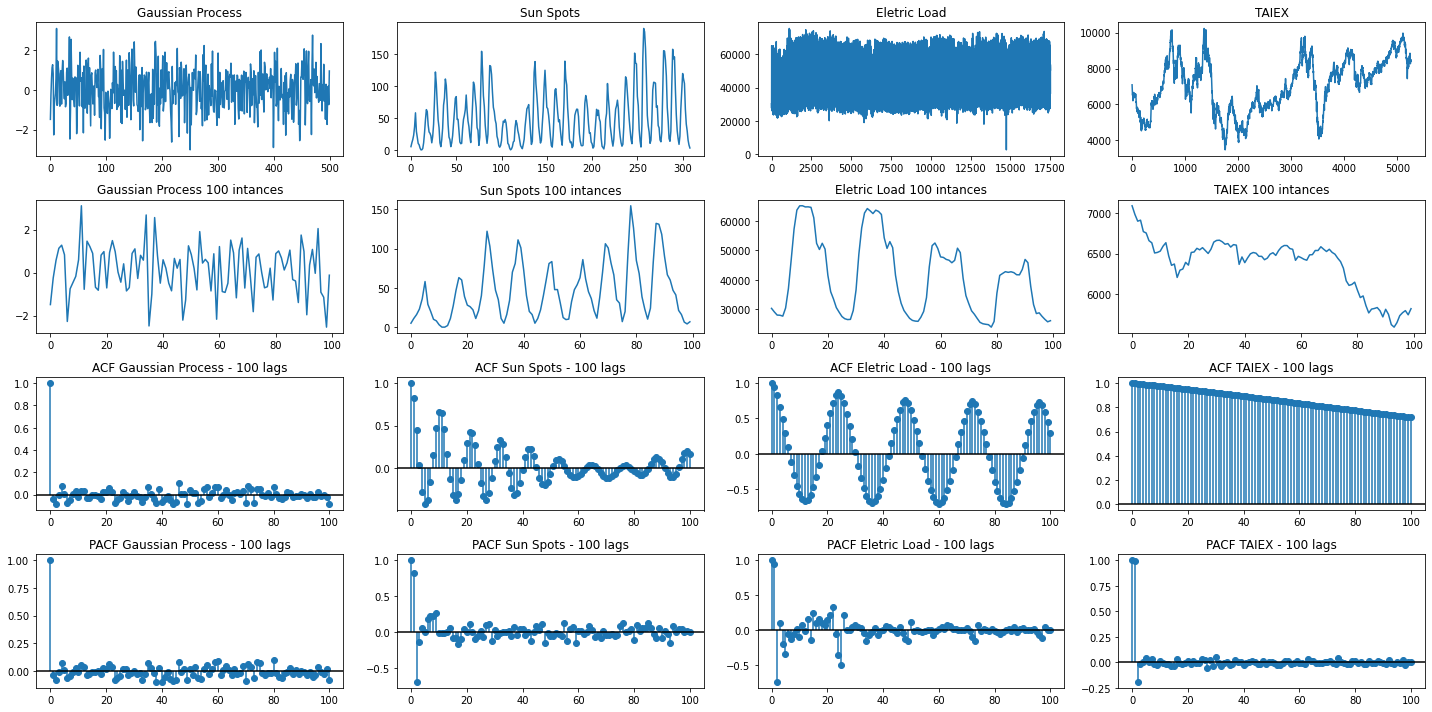

In [3]:
from pyFTS.data import TAIEX, Malaysia, sunspots, artificial
from statsmodels.tsa.stattools import acf, pacf

datasets = {}

datasets['Gaussian Process'] = artificial.white_noise()
datasets['Sun Spots'] = sunspots.get_data()
datasets['Eletric Load'] = Malaysia.get_data('load')
datasets['TAIEX'] = TAIEX.get_data()
#datasets['Temperature'] = Malaysia.get_data('temperature')


fig, ax = plt.subplots(nrows=4, ncols=4, figsize=[20,10])

for ct, (key, data) in enumerate(datasets.items()): 
  _lags = np.arange(0,101)
  _acf = acf(data,nlags=100)
  _pacf = pacf(data,nlags=100)
  
  ax[0][ct].set_title("{}".format(key))
  ax[0][ct].plot(data)
  
  ax[1][ct].set_title("{} 100 intances".format(key))
  ax[1][ct].plot(data[:100])
  
  ax[2][ct].set_title("ACF {} - 100 lags".format(key))
  ax[2][ct].plot(_lags, _acf, "o")
  ax[2][ct].vlines(_lags,[0],_acf)
  ax[2][ct].axhline(y=0, color='black')
  
  ax[3][ct].set_title("PACF {} - 100 lags".format(key))
  ax[3][ct].plot(_lags, _pacf, "o")
  ax[3][ct].vlines(_lags,[0],_pacf)
  ax[3][ct].axhline(y=0, color='black')

plt.tight_layout()


## Processo Geral

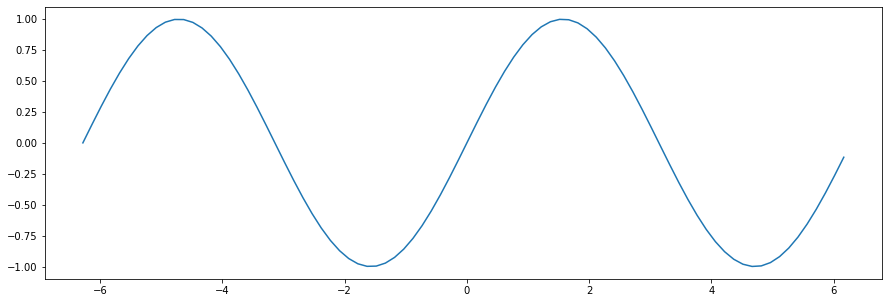

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[15,5])

x = [k for k in np.arange(-2*np.pi, 2*np.pi, 0.15)] 
l = len(x)
y = [np.sin(k) for k in x]
#y += np.random.normal(0, 0.1, l)

ax.plot(x, y)

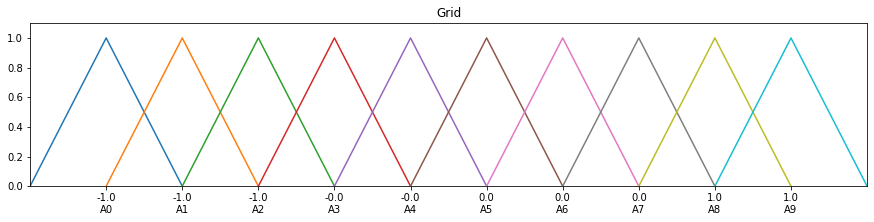

In [5]:
!pip3 install SimpSOM
from pyFTS.data import Enrollments
from pyFTS.partitioners import Grid
from pyFTS.models import hofts

dados_treino = y[:60] 

dados_teste = y[60:]

#Particionamento do Universo de Discurso
particionador = Grid.GridPartitioner(data=dados_treino,npart=10, freq = 1)

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[15,3])

particionador.plot(ax)


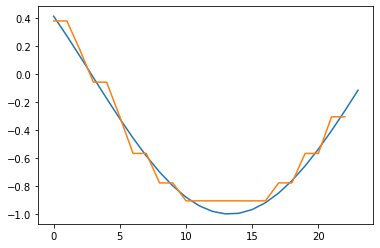

In [6]:

# Cria um modelo vazio
#modelo = hofts.HighOrderFTS(partitioner=particionador, order=1)
modelo = hofts.WeightedHighOrderFTS(partitioner=particionador, order=1)


# Todo o procedimento de treinamento é feito pelo método fit
modelo.fit(dados_treino)

# Todo o procedimento de inferência é feito pelo método predict
predicoes = modelo.predict(dados_teste)

if modelo.order > 1:
  for k in range(modelo.order):
    predicoes.insert(0,None)


plt.plot(dados_teste)
plt.plot(predicoes)

In [7]:
print(modelo)

Weighted High Order FTS:
A0 -> A0 (0.417), A1 (0.5), A2 (0.083)
A1 -> A1 (0.458), A2 (0.25), A0 (0.25), A3 (0.042)
A2 -> A2 (0.389), A3 (0.167), A1 (0.333), A0 (0.056), A4 (0.056)
A3 -> A2 (0.25), A3 (0.333), A1 (0.083), A4 (0.25), A5 (0.083)
A4 -> A5 (0.286), A6 (0.143), A4 (0.286), A3 (0.214), A2 (0.071)
A5 -> A5 (0.312), A6 (0.312), A7 (0.125), A4 (0.188), A3 (0.062)
A6 -> A6 (0.333), A7 (0.333), A8 (0.111), A5 (0.167), A4 (0.056)
A7 -> A6 (0.222), A7 (0.333), A8 (0.278), A9 (0.111), A5 (0.056)
A8 -> A8 (0.433), A9 (0.4), A7 (0.133), A6 (0.033)
A9 -> A8 (0.333), A9 (0.611), A7 (0.056)



## Explorando os hiperparâmetros

### Explorando o Número de Partições

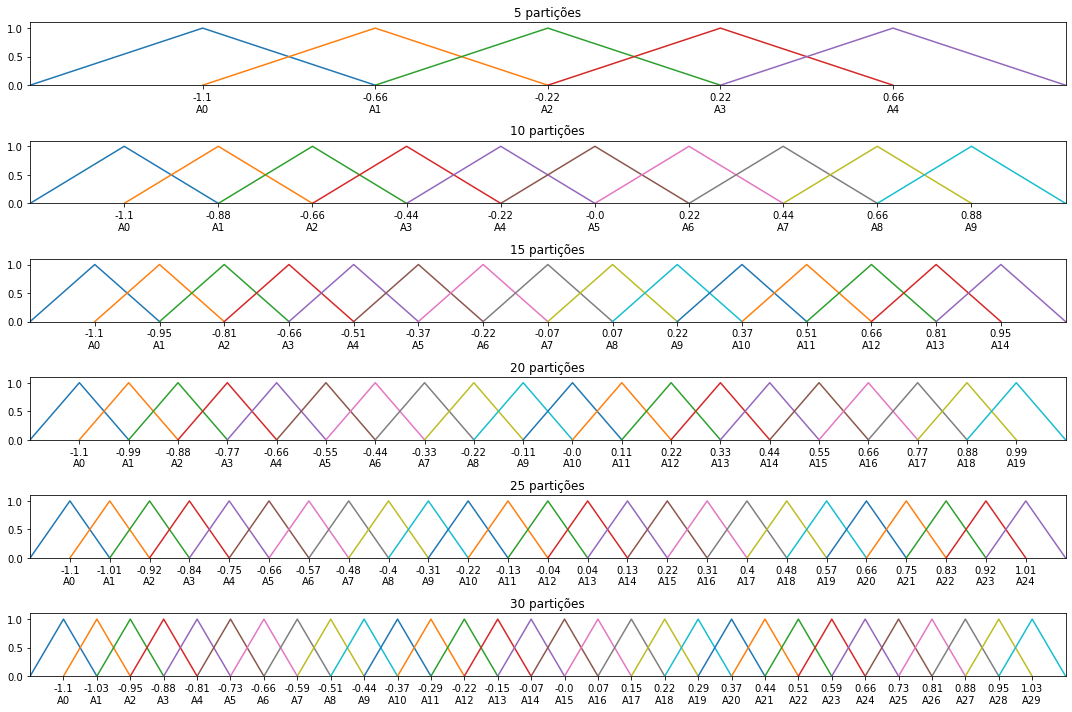

In [8]:
from pyFTS.models import hofts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures
rows = []


fig, ax = plt.subplots(nrows=6, ncols=1,figsize=[15,10])


for ct, npart in enumerate(np.arange(5,35,5)):
  part = Grid.GridPartitioner(data=y, npart=npart)
  part.name = str(npart) + " partições"
  
  part.plot(ax[ct], rounding=2)
 
plt.tight_layout()

,Partitions,RMSE,MAPE,U
0,5,0.25,76.41,2.42
1,10,0.13,51.20,1.21
2,15,0.09,35.81,0.85
3,20,0.06,23.47,0.58
4,25,0.04,19.14,0.38
5,30,0.03,10.71,0.29
6,35,0.02,6.82,0.22


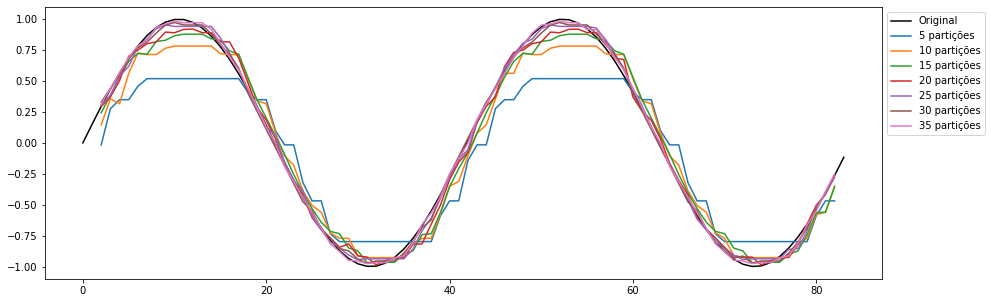

In [9]:
from pyFTS.models import hofts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures
rows = []


fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[15,5])

ax.plot(y, label='Original',color='black')

for npart in np.arange(5,40,5):
  part = Grid.GridPartitioner(data=y, npart=npart)
  model = hofts.WeightedHighOrderFTS(order=2, partitioner=part)
  model.fit(y)
  forecasts = model.predict(y)
  for o in range(model.order):
    forecasts.insert(0,None)
    
  ax.plot(forecasts[:-1], label=str(npart) + " partições")
  
  rmse, mape, u = Measures.get_point_statistics(y, model)
  
  rows.append([npart, rmse, mape, u])
  

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))

pd.DataFrame(rows, columns=['Partitions','RMSE','MAPE','U'])

### Explorando o Tipo de Particionamento

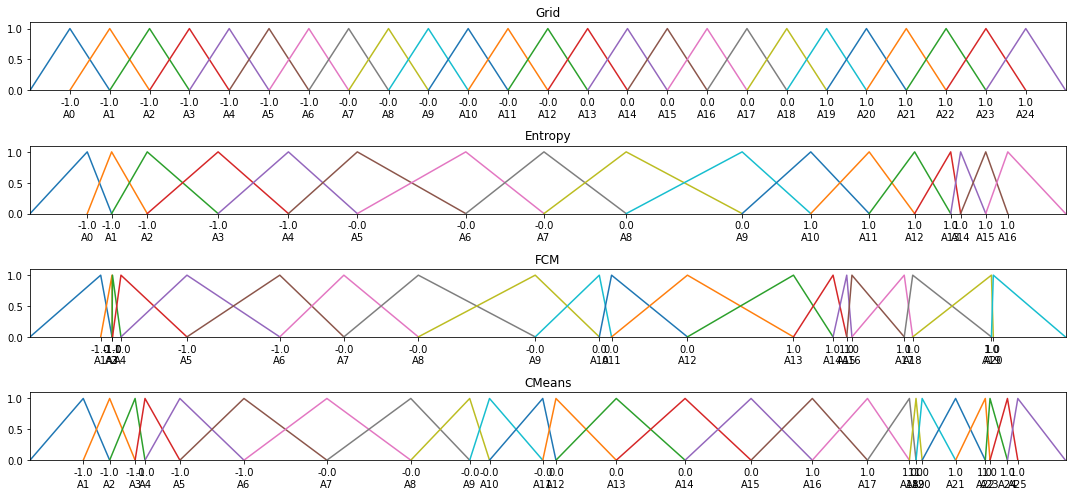

In [10]:
from pyFTS.partitioners import Grid, FCM, CMeans, Entropy

metodos = [Grid.GridPartitioner, Entropy.EntropyPartitioner, FCM.FCMPartitioner, CMeans.CMeansPartitioner ]

k = 25

fig, ax = plt.subplots(nrows=4, ncols=1,figsize=[15,7])

for contador, metodo in enumerate(metodos):
  particionador = metodo(data=y, npart=k)
  particionador.plot(ax[contador])
  
plt.tight_layout()

,Partitions,RMSE,MAPE,U
0,Grid,0.05,19.79,0.45
1,Entropy,0.07,25.71,0.64
2,FCM,0.07,35.55,0.67
3,CMeans,0.03,8.49,0.29


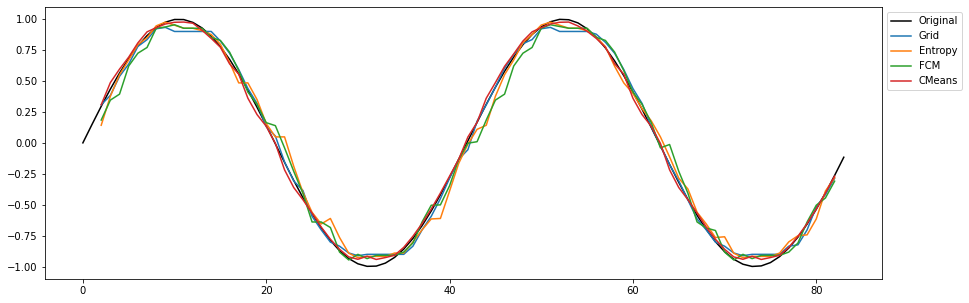

In [11]:
from pyFTS.models import hofts
from pyFTS.partitioners import Grid, FCM, CMeans, Entropy
from pyFTS.benchmarks import Measures

metodos = [Grid.GridPartitioner, Entropy.EntropyPartitioner, FCM.FCMPartitioner, CMeans.CMeansPartitioner ]

k = 25

rows = []


fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[15,5])

ax.plot(y, label='Original',color='black')

for contador, metodo in enumerate(metodos):
  part = metodo(data=y, npart=k)
  model = hofts.HighOrderFTS(order=2, partitioner=part)
  model.fit(y)
  forecasts = model.predict(y)
  for o in range(model.order):
    forecasts.insert(0,None)
    
  ax.plot(forecasts[:-1], label=part.name)
  
  rmse, mape, u = Measures.get_point_statistics(y, model)
  
  rows.append([part.name, rmse, mape, u])
  

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))

pd.DataFrame(rows, columns=['Partitions','RMSE','MAPE','U'])

### Explorando a Função de Pertinência

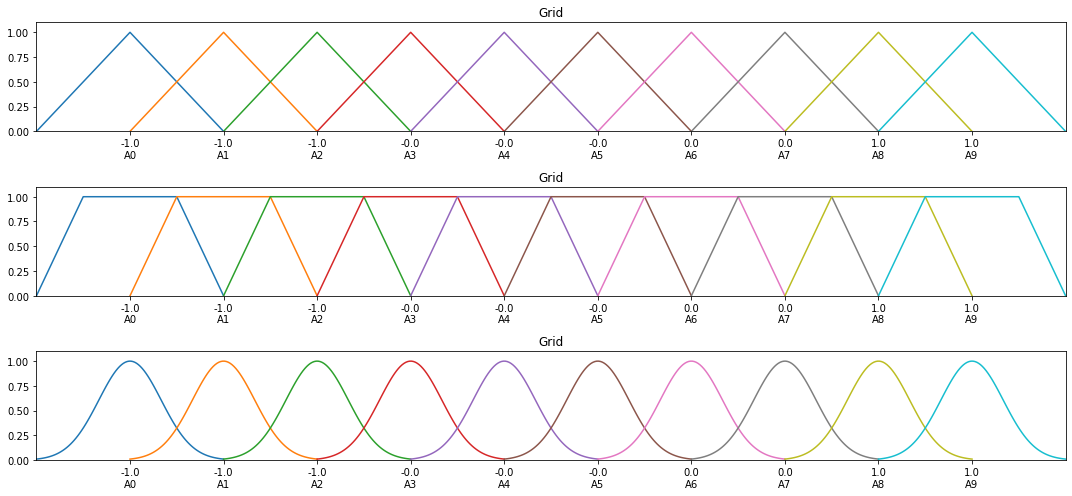

In [12]:
from pyFTS.partitioners import Grid
from pyFTS.common import Membership

functions = [Membership.trimf, Membership.trapmf, Membership.gaussmf]

k = 10

fig, ax = plt.subplots(nrows=3, ncols=1,figsize=[15,7])

for contador, mf in enumerate(functions):
  particionador = Grid.GridPartitioner(data=y, npart=k, func=mf)
  particionador.plot(ax[contador])
  
plt.tight_layout()

,Partitions,RMSE,MAPE,U
0,Grid,0.05,19.79,0.45
1,Grid,0.05,20.00,0.47
2,Grid,0.08,18.75,0.78


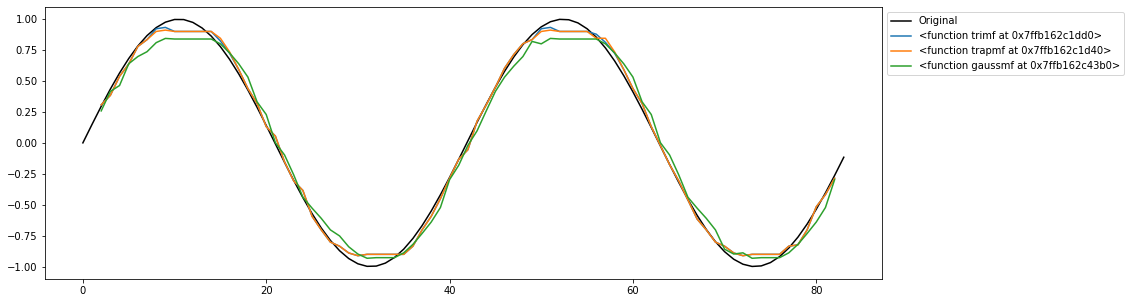

In [13]:
from pyFTS.models import hofts
from pyFTS.partitioners import Grid, FCM, CMeans, Entropy
from pyFTS.benchmarks import Measures

functions = [Membership.trimf, Membership.trapmf, Membership.gaussmf]

k = 25


rows = []


fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[15,5])

ax.plot(y, label='Original',color='black')

for contador, mf in enumerate(functions):
  part = Grid.GridPartitioner(data=y, npart=k, func=mf)
  model = hofts.HighOrderFTS(order=2, partitioner=part)
  model.fit(y)
  forecasts = model.predict(y)
  for o in range(model.order):
    forecasts.insert(0,None)
    
  ax.plot(forecasts[:-1], label=str(mf))
  
  rmse, mape, u = Measures.get_point_statistics(y, model)
  
  rows.append([part.name, rmse, mape, u])
  

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))

pd.DataFrame(rows, columns=['Partitions','RMSE','MAPE','U'])

### Explorando a Ordem do Modelo

,Order,RMSE,MAPE,U
0,1,0.12,71.50,1.17
1,2,0.09,35.81,0.85
2,3,0.05,10.88,0.49


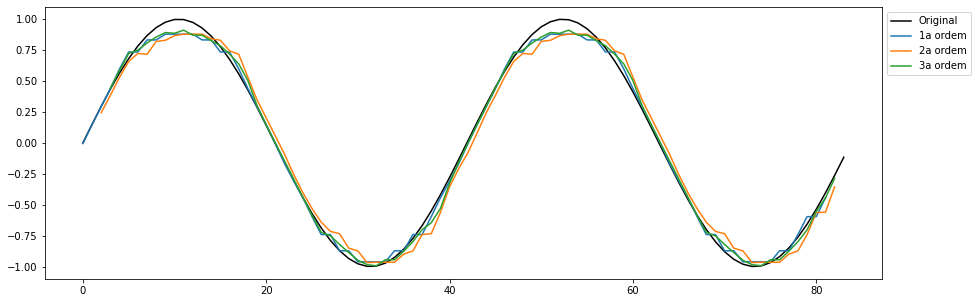

In [14]:
from pyFTS.models import hofts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures
rows = []

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[15,5])

ax.plot(y, label='Original',color='black')

for order in np.arange(1,4):
  part = Grid.GridPartitioner(data=y, npart=15)
  model = hofts.WeightedHighOrderFTS(order=order, partitioner=part)
  model.fit(y)
  forecasts = model.predict(y)
  if order > 1:
    for k in np.arange(order):
      forecasts.insert(0,None)

  ax.plot(forecasts[:-1], label=str(order) + "a ordem")
  
  rmse, mape, u = Measures.get_point_statistics(y, model)
  
  rows.append([order, rmse, mape, u])
  

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))

pd.DataFrame(rows, columns=['Order','RMSE','MAPE','U'])

In [15]:
part = Grid.GridPartitioner(data=y, npart=15)
model = hofts.WeightedHighOrderFTS(order=3, partitioner=part)
model.fit(y)

print(model)

Weighted High Order FTS:
A2,A1,A1 -> A0 (0.5), A1 (0.5)
A3,A1,A1 -> A0 (0.5), A1 (0.5)
A3,A1,A2 -> A0 (0.5), A1 (0.5)
A1,A2,A0 -> A0 (0.5), A1 (0.5)
A2,A1,A0 -> A0 (0.5), A1 (0.5)
A2,A2,A0 -> A0 (0.5), A1 (0.5)
A2,A0,A0 -> A0 (0.5), A1 (0.5)
A2,A0,A1 -> A0 (0.5), A1 (0.5)
A1,A1,A0 -> A0 (0.375), A1 (0.5), A2 (0.125)
A2,A2,A1 -> A1 (0.5), A2 (0.167), A0 (0.333)
A1,A0,A0 -> A0 (0.333), A1 (0.5), A2 (0.167)
A3,A2,A1 -> A1 (0.5), A2 (0.25), A0 (0.25)
A1,A0,A1 -> A0 (0.25), A1 (0.5), A2 (0.25)
A0,A0,A0 -> A0 (0.25), A1 (0.5), A2 (0.25)
A0,A1,A0 -> A0 (0.25), A1 (0.5), A2 (0.25)
A3,A2,A2 -> A1 (0.5), A2 (0.333), A0 (0.167)
A1,A1,A1 -> A0 (0.25), A1 (0.417), A2 (0.25), A3 (0.083)
A0,A0,A1 -> A0 (0.167), A1 (0.5), A2 (0.333)
A3,A3,A2 -> A1 (0.5), A2 (0.5)
A4,A2,A2 -> A1 (0.5), A2 (0.5)
A4,A2,A3 -> A1 (0.5), A2 (0.5)
A2,A3,A1 -> A1 (0.5), A2 (0.5)
A3,A3,A1 -> A1 (0.5), A2 (0.5)
A1,A2,A1 -> A0 (0.25), A1 (0.25), A2 (0.25), A3 (0.25)
A0,A1,A1 -> A0 (0.125), A1 (0.375), A2 (0.375), A3 (0.125)
A0,A

### Explorando os Tipos de Modelos

,Partitions,RMSE,MAPE,U
0,Conventional FTS,0.06,10.36,0.59
1,Trend Weighted FTS,0.06,9.47,0.57
2,High Order FTS,0.02,6.51,0.23
3,Weighted High Order FTS,0.02,6.44,0.21
4,Probabilistic FTS,0.01,3.33,0.13


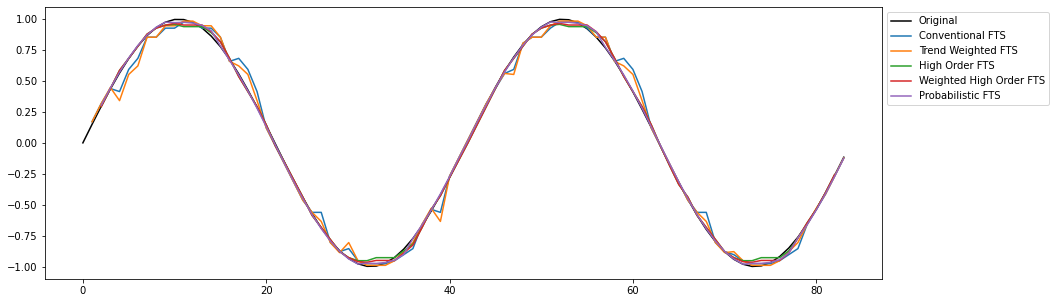

In [16]:
from pyFTS.models import chen, cheng, hofts, pwfts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures

metodos = [chen.ConventionalFTS, cheng.TrendWeightedFTS, hofts.HighOrderFTS, 
          hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]

k = 45

rows = []


fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[15,5])

ax.plot(y, label='Original',color='black')

part = Grid.GridPartitioner(data=y, npart=k)

for contador, metodo in enumerate(metodos):
  model = metodo(partitioner=part)
  if model.is_high_order:
    model = metodo(partitioner=part, order=2)
  model.fit(y)
  forecasts = model.predict(y)
  for o in range(model.order):
    forecasts.insert(0,None)
    
  ax.plot(forecasts[:-1], label=model.name)
  
  rmse, mape, u = Measures.get_point_statistics(y, model)
  
  rows.append([model.name, rmse, mape, u])
  
  #print(model)
  

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))

pd.DataFrame(rows, columns=['Partitions','RMSE','MAPE','U'])

In [17]:
from pyFTS.models import chen, cheng, hofts, pwfts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures

metodos = [chen.ConventionalFTS, cheng.TrendWeightedFTS, hofts.HighOrderFTS, 
          hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]

k = 15

part = Grid.GridPartitioner(data=y, npart=k)

for contador, metodo in enumerate(metodos):
  model = metodo(partitioner=part)
  if model.is_high_order:
    model = metodo(partitioner=part, order=2)
  model.fit(y)
  print(model)

Conventional FTS:
A1 -> A1,A2
A2 -> A1,A2,A3
A3 -> A2,A4
A4 -> A3,A4,A5
A5 -> A4,A6
A6 -> A5,A7
A7 -> A6,A8
A8 -> A7,A9
A9 -> A10,A8
A10 -> A10,A11,A9
A11 -> A10,A11,A12
A12 -> A11,A13
A13 -> A12,A13,A14
A14 -> A13,A14

Trend Weighted FTS:
A1 -> A1(0.011),A1(0.022),A1(0.033),A1(0.044),A1(0.055),A1(0.066),A1(0.077),A1(0.088),A1(0.099),A1(0.11),A1(0.121),A2(0.132),A2(0.143)
A2 -> A1(0.036),A1(0.071),A2(0.107),A2(0.143),A2(0.179),A3(0.214),A3(0.25)
A3 -> A2(0.1),A2(0.2),A4(0.3),A4(0.4)
A4 -> A3(0.048),A3(0.095),A4(0.143),A4(0.19),A5(0.238),A5(0.286)
A5 -> A4(0.1),A4(0.2),A6(0.3),A6(0.4)
A6 -> A5(0.1),A5(0.2),A7(0.3),A7(0.4)
A7 -> A6(0.167),A6(0.333),A8(0.5)
A8 -> A7(0.1),A7(0.2),A9(0.3),A9(0.4)
A9 -> A10(0.1),A10(0.2),A8(0.3),A8(0.4)
A10 -> A10(0.067),A11(0.133),A11(0.2),A9(0.267),A9(0.333)
A11 -> A10(0.067),A10(0.133),A11(0.2),A12(0.267),A12(0.333)
A12 -> A11(0.1),A11(0.2),A13(0.3),A13(0.4)
A13 -> A12(0.028),A12(0.056),A13(0.083),A13(0.111),A13(0.139),A13(0.167),A14(0.194),A14(0.222)
A14

In [ ]:
model.

## Tipos de Predições

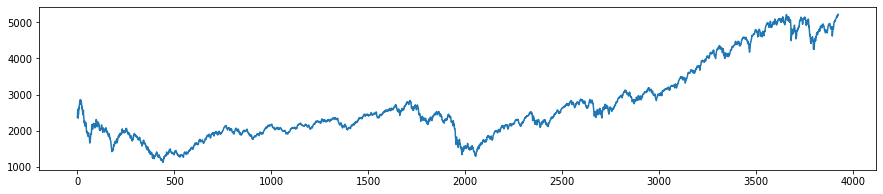

In [18]:
from pyFTS.data import NASDAQ
from statsmodels.tsa.stattools import acf, pacf

data = NASDAQ.get_data()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15,3])

ax.plot(data)

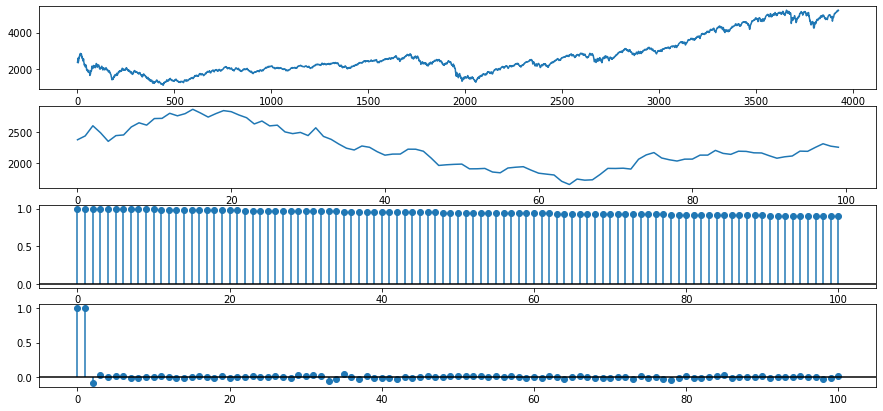

In [19]:

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=[15,7])

_lags = np.arange(0,101)
_acf = acf(data,nlags=100)
_pacf = pacf(data,nlags=100)

ax[0].plot(data)

ax[1].plot(data[:100])

ax[2].plot(_lags, _acf, "o")
ax[2].vlines(_lags,[0],_acf)
ax[2].axhline(y=0, color='black')

ax[3].plot(_lags, _pacf, "o")
ax[3].vlines(_lags,[0],_pacf)
ax[3].axhline(y=0, color='black')


In [20]:
from pyFTS.partitioners import Grid
from pyFTS.models import hofts

treino = data[:1500]
teste = data[1500:2500]

particionador = Grid.GridPartitioner(data=treino, npart=33)





### Predição por ponto, um passo à frente

In [ ]:

modelo = hofts.HighOrderFTS(partitioner=particionador, order=2)
modelo.fit(treino)

predicoes = modelo.predict(teste)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15,3])

ax.plot(teste)
ax.plot(predicoes)

### Predição por ponto, H passos à frente

In [ ]:

modelo = hofts.HighOrderFTS(partitioner=particionador, order=2)
modelo.fit(treino)

predicoes = modelo.predict(teste, steps_ahead=50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15,3])

ax.plot(teste[:50])
ax.plot(predicoes)

### Predição por intervalo, um passo à frente

In [ ]:
from pyFTS.models import ifts
from pyFTS.common import Util

model1 = ifts.IntervalFTS(partitioner=particionador, order=1)
model1.fit(treino)

model2 = ifts.WeightedIntervalFTS(partitioner=particionador, order=1)
model2.fit(treino)


In [ ]:
horizon=40

intervals1 = model1.predict(teste[:horizon], type='interval')
intervals2 = model2.predict(teste[:horizon], type='interval')

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[15,5])
ax.plot(teste[:horizon], label='Original',color='black')
Util.plot_interval2(intervals1, teste[:horizon], start_at=model1.order-1, ax=ax, color='orange', ls='--', label='IFTS')
Util.plot_interval2(intervals2, teste[:horizon], start_at=model2.order-1, ax=ax, color='red', ls='--', label='WIFTS')

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, 
          fancybox=True, shadow=True, ncol=5, loc='lower center', bbox_to_anchor=(0.5, -0.05))


### Predição por intervalos, H passos à frente

In [ ]:
horizon=10

intervals1 = model1.predict(teste[:10], type='interval', steps_ahead=horizon)
intervals2 = model2.predict(teste[:10], type='interval', steps_ahead=horizon)

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[15,5])
ax.plot(teste[:11], label='Original',color='black')
Util.plot_interval2(intervals1, teste[:10], start_at=model1.order-1, ax=ax, color='orange', ls='--', label='IFTS')
Util.plot_interval2(intervals2, teste[:10], start_at=model2.order-1, ax=ax, color='red', ls='--', label='WIFTS')

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, 
          fancybox=True, shadow=True, ncol=5, loc='lower center', bbox_to_anchor=(0.5, -0.05))


### Predição probabilística, um passo à frente

In [ ]:
from pyFTS.models import pwfts

model = pwfts.ProbabilisticWeightedFTS(partitioner=particionador, order=1)
model.fit(treino)

forecasts = model.predict(teste[:20], type='point')
intervals = model.predict(teste[:20], type='interval')
distributions = model.predict(teste[:20], type='distribution')

forecasts.insert(0,teste[0])
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[15,5])
ax.plot(teste[:21], label='Original',color='black')
ax.plot(forecasts[:-1], label='Point',color='brown')
Util.plot_interval2(intervals, teste[:10], start_at=model.order-1, ax=ax, color='orange', ls='--', label='Interval')
Util.plot_distribution2(distributions, teste[:10], start_at=model.order-1, ax=ax, cmap="Blues")

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, 
          fancybox=True, shadow=True, ncol=5, loc='lower center', bbox_to_anchor=(0.5, -0.05))

In [ ]:
Util.plot_distribution_tiled(distributions,rows=5,cols=3,size=[10,10])

In [ ]:
print(model)

### Predição probabilística, H passos à frente

In [ ]:
horizon=10

forecasts = model.predict(teste[9:20], type='point', steps_ahead=horizon)
intervals = model.predict(teste[9:20], type='interval', steps_ahead=horizon)
distributions = model.predict(teste[9:20], type='distribution', steps_ahead=horizon)

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[15,5])
ax.plot(teste[:20], label='Original',color='black')
for k in range(9):
  forecasts.insert(0,None)
forecasts.insert(9,teste[9])
ax.plot(forecasts, label='Point',color='brown')
Util.plot_interval2(intervals, teste[:20], start_at=9, ax=ax, color='red', ls='--', label='WIFTS')
Util.plot_distribution2(distributions, teste[:20], start_at=9, ax=ax, cmap="Blues")

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, 
          fancybox=True, shadow=True, ncol=5, loc='lower center', bbox_to_anchor=(0.5, -0.05))


In [ ]:
Util.plot_distribution_tiled(distributions,rows=5,cols=2,size=[10,7])

## Métodos Multivariados (MVFTS)

### Série de Irradiação Solar

In [ ]:
dataset = pd.read_csv('../content/sample_data/SONDA_HOURLY.csv', sep=';')
#dataset2 =  pd.read_csv('../content/sample_data/DadosCrus.csv', sep=';')
#print(dataset2)

#dataset['data'] = pd.to_datetime(dataset["data"], format='%dd/%mm/%YYYY %HH:%MM')
dataset['data'] = pd.to_datetime(dataset["data"], format='%d/%m/%Y %H:%M')

train = dataset.iloc[:600]
test = dataset.iloc[:800]

dataset.head()

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=[15,5])

ax[0].plot(train['glo_avg'].values[:240])
ax[1].plot(train['glo_avg'].values)

### Variáveis e Particionamento

In [ ]:
from pyFTS.models.multivariate import common, variable, mvfts
from pyFTS.models.seasonal import partitioner as seasonal
from pyFTS.models.seasonal.common import DateTime

fig, ax = plt.subplots(nrows=7, ncols=1, figsize=[15,24])

sp = {'seasonality': DateTime.day_of_year , 'names': ['Jan','Fev','Mar','Abr','Mai','Jun','Jul', 'Ago','Set','Out','Nov','Dez']}

vmonth = variable.Variable("Month", data_label="data", partitioner=seasonal.TimeGridPartitioner, npart=12, 
                           data=train, partitioner_specific=sp)

vmonth.partitioner.plot(ax[0])

sp = {'seasonality': DateTime.minute_of_day, 'names': [str(k)+'hs' for k in range(0,24)]}

vhour = variable.Variable("Hour", data_label="data", partitioner=seasonal.TimeGridPartitioner, npart=24, 
                          data=train, partitioner_specific=sp)

vhour.partitioner.plot(ax[1])

vavg = variable.Variable("Radiation", data_label="glo_avg", alias='rad',
                         partitioner=Grid.GridPartitioner, npart=35,  
                         data=train)  

vavg.partitioner.plot(ax[2])

vpot = variable.Variable("Potencia", data_label="AL_Pot",
                         partitioner=Grid.GridPartitioner, npart=10,  
                         data=train)  

vpot.partitioner.plot(ax[3])

vvazao = variable.Variable("Vazao", data_label="Vazao",
                         partitioner=Grid.GridPartitioner, npart=15,  
                         data=train)  

vvazao.partitioner.plot(ax[4])

vtor = variable.Variable("Torque", data_label="Torque",
                         partitioner=Grid.GridPartitioner, npart=5,  
                         data=train)  

vtor.partitioner.plot(ax[5])

vvel = variable.Variable("AL Speed", data_label="AL_Speed",
                         partitioner=Grid.GridPartitioner, npart=12,  
                         data=train)  

vvel.partitioner.plot(ax[6])

plt.tight_layout()

### Treinamento e Avaliação dos Modelos MVFTS

In [ ]:
from pyFTS.models.multivariate import mvfts, wmvfts, cmvfts, granular

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15,3])

ax.plot(test['glo_avg'].values[:100],label='Original')

model1 = mvfts.MVFTS(explanatory_variables=[vmonth, vhour, vavg, vpot, vvazao, vvel], target_variable=vavg)
model2 = wmvfts.WeightedMVFTS(explanatory_variables=[vmonth, vhour, vavg, vpot, vvazao, vvel], target_variable=vavg)
model3 = granular.GranularWMVFTS(explanatory_variables=[vmonth, vhour, vavg, vpot, vvazao, vvel], target_variable=vavg, 
                                 order=2, knn=2)

rows = []

for ct, model in enumerate([model1, model2, model3]):
  
  model.fit(train)
  
  forecasts = model.predict(test.iloc[:100])
  if model.is_high_order:
    for k in range(model.order):
      forecasts.insert(0,None)
  ax.plot(forecasts[:100], label=model.shortname)
  rmse, mape, u = Measures.get_point_statistics(test, model)
  
  rows.append([model.name, rmse, u])
  

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))

pd.DataFrame(rows, columns=['Model','RMSE','U'])


## Métodos Variantes no Tempo

In [ ]:
from pyFTS.data import NASDAQ

data = NASDAQ.get_data()

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[15,5])

ax.plot(data)

In [ ]:
window = 100

batch = 50

num_models = 3

In [ ]:
from pyFTS.models.incremental import TimeVariant, IncrementalEnsemble
from pyFTS.models.nonstationary import common, perturbation, partitioners as nspart
from pyFTS.models.nonstationary import nsfts, util as nsUtil
from pyFTS.partitioners import Grid
from pyFTS.models import hofts

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15,5])
ax.plot(test, color='black', label='original')

train = data[:2000]
test = data[2000:]

model1 = TimeVariant.Retrainer(partitioner_method=Grid.GridPartitioner, partitioner_params={'npart': 35},
                              fts_method=hofts.WeightedHighOrderFTS, fts_params={}, order=2 ,
                              batch_size=batch, window_length=window*num_models)

model2 = IncrementalEnsemble.IncrementalEnsembleFTS(partitioner_method=Grid.GridPartitioner, partitioner_params={'npart': 35},
                              fts_method=hofts.WeightedHighOrderFTS, fts_params={}, order=2 ,
                              batch_size=int(batch/3), window_length=window, num_models=num_models)

nsfs = nspart.simplenonstationary_gridpartitioner_builder(data=train, npart=35, transformation=None)
model3 = nsfts.NonStationaryFTS(partitioner=nsfs)



rows = []
  
for model in [model1, model2, model3]:
  model.fit(train)
  forecasts = model.predict(test)
  for k in range(model.max_lag):
    forecasts.insert(0,None)
    
  rmse, mape, u = Measures.get_point_statistics(test, model)
  rows.append([model.name, rmse, u])

  ax.plot(forecasts, label=model.shortname)

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))

pd.DataFrame(rows, columns=['Model','RMSE','U'])